# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In this project I will be trying to understand which factors will be affecting the used car price the most. In order to get the bested results we will be focusing on the factors such as the year the car was sold and how many miles are on the odometer (Numerical factors). 

In [96]:
#Importing in the required packages for this project 
import pandas as pd
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [64]:
#Import in the data file and understand the different columns 
car = pd.read_csv("data/vehicles.csv")
car.head()


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [65]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [66]:
#Cleaning the data will require dropping all NaN rows as well as any other information
#we do not need like non-numerical data
df = car.dropna()
df = df[df['price'] != 0]

In [67]:
df.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [68]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al
268,7315946365,birmingham,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al
337,7315354216,birmingham,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,1FTMF1CM6BKD55331,fwd,full-size,truck,white,al
338,7315349921,birmingham,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,1.14023E+13,rwd,full-size,coupe,silver,al


### A Price Distribution ###

Histogram to show the distribution of car prices

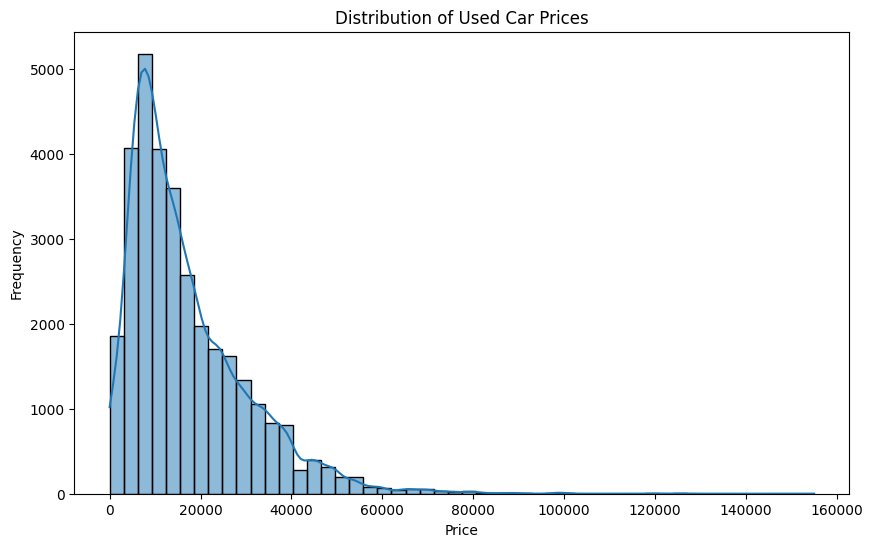

In [83]:
plt.figure(figsize= (10, 6))
sns.histplot(df['price'], bins = 50, kde = True)
plt.title('Distribution of Used Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

### Price vs Year ###
Scatter plot to show depreciation over time

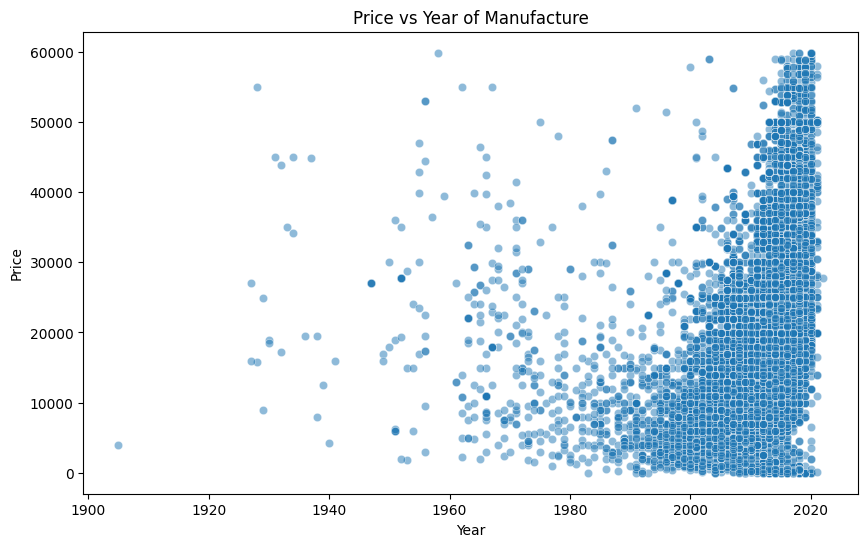

In [89]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = car['year'], y = df['price'], alpha = 0.5)
plt.title('Price vs Year of Manufacture')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [99]:
# Feature Engineering
df['car_age'] = datetime.now().year - df['year']
df['price_per_mile'] = df['price'] / (df['odometer'] + 1)  # Avoid division by zero
luxury_brands = ['BMW', 'Mercedes-Benz', 'Audi', 'Lexus', 'Porsche', 'Tesla']
df['is_luxury'] = df['manufacturer'].apply(lambda x: 1 if x in luxury_brands else 0)

# Define Features and Target
X = df.drop(columns=['price'])  # Features
y = df['price']  # Target variable

# Identify Feature Types
numerical_features = ['car_age', 'odometer', 'price_per_mile', 'is_luxury']
categorical_features = ['manufacturer', 'fuel', 'transmission']

# Preprocessing Pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
])

# Define Model Pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Model
model_pipeline.fit(X_train, y_train)

# Evaluate Model Performance
cross_val_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
rmse = -np.mean(cross_val_scores)

print(f"Baseline Linear Regression RMSE: {rmse:.2f}")

Baseline Linear Regression RMSE: 8198267.91


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [100]:
# Get feature names after preprocessing
feature_names = numerical_features  # Start with numerical features

# Add categorical feature names from OneHotEncoder
onehot_categories = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([feature_names, onehot_categories])

# Extract model coefficients
coefficients = model_pipeline.named_steps['model'].coef_

# Create a DataFrame for better visualization
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient'].abs()  # Use absolute value to rank

# Sort by absolute coefficient value (strongest impact)
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)

# Display top 10 most important features
print(feature_importance.head(10))

                         Feature    Coefficient  Absolute_Coefficient
45            manufacturer_volvo  407307.473604         407307.473604
30    manufacturer_mercedes-benz  314111.686084         314111.686084
13           manufacturer_datsun -263753.273488         263753.273488
2                 price_per_mile  214244.706695         214244.706695
1                       odometer  151573.532583         151573.532583
36          manufacturer_pontiac -117289.514778         117289.514778
43           manufacturer_toyota  107733.813026         107733.813026
31          manufacturer_mercury  -98941.272344          98941.272344
19  manufacturer_harley-davidson  -81208.455465          81208.455465
52           transmission_manual   76833.031646          76833.031646


/var/folders/19/_djhhd2d4j1drxs9ryt60rtm0000gn/T/ipykernel_17405/2503294416.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


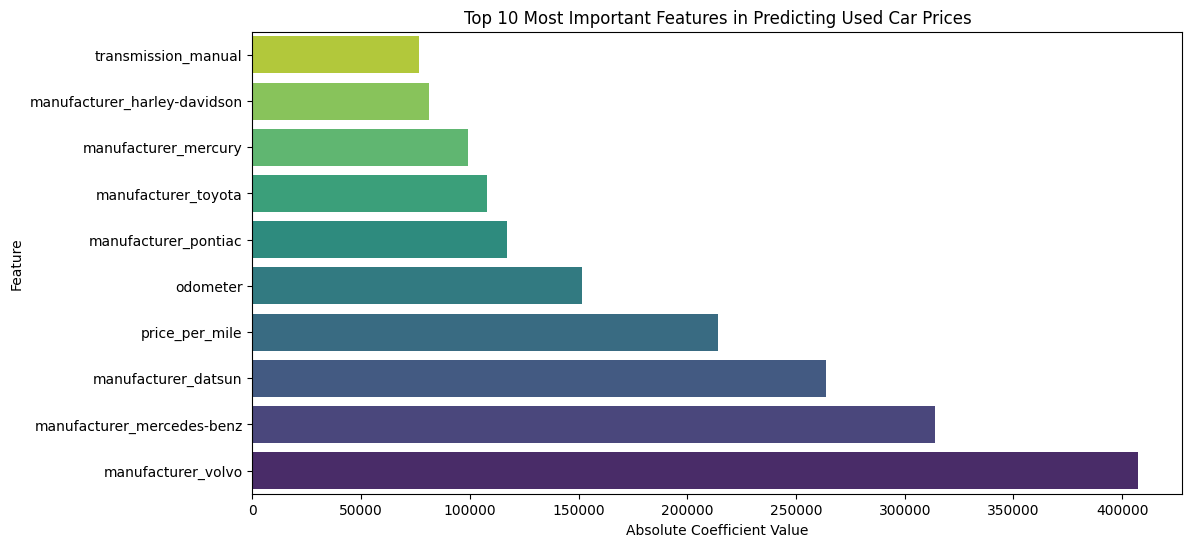

In [101]:
# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(
    x=feature_importance['Absolute_Coefficient'][:10], 
    y=feature_importance['Feature'][:10], 
    palette="viridis"
)

plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features in Predicting Used Car Prices")
plt.gca().invert_yaxis()  # Largest importance on top
plt.show()

## Trying a more advanced model: Random Forest ##

In [102]:
# Reoad the dataset
df = pd.read_csv("data/vehicles.csv") 

# Feature Engineering
df['car_age'] = datetime.now().year - df['year']
df['price_per_mile'] = df['price'] / (df['odometer'] + 1)

luxury_brands = ['BMW', 'Mercedes-Benz', 'Audi', 'Lexus', 'Porsche', 'Tesla']
df['is_luxury'] = df['manufacturer'].apply(lambda x: 1 if x in luxury_brands else 0)

# Define Features and Target
X = df.drop(columns=['price'])  # Features
y = df['price']  # Target variable

# Identify Feature Types
numerical_features = ['car_age', 'odometer', 'price_per_mile', 'is_luxury']
categorical_features = ['manufacturer', 'fuel', 'transmission']

# Preprocessing Pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
])

# Define the Full Pipeline with Model
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=10, random_state=42))
])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Model
rf_pipeline.fit(X_train, y_train)

# Evaluate the Model
cross_val_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
rmse = -np.mean(cross_val_scores)

print(f"Cross-validated RMSE: {rmse:.2f}")

Cross-validated RMSE: 5836333.20


In [104]:
# Extract Random Forest Feature Importance
rf_importance = rf_pipeline.named_steps['model'].feature_importances_

# Create DataFrame for better readability
rf_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importance
})

# Sort the features by importance score
rf_feature_importance = rf_feature_importance.sort_values(by='Importance', ascending=False)

# Display top 10 most important features
print(rf_feature_importance.head(10))

                       Feature  Importance
1                     odometer    0.651107
2               price_per_mile    0.277020
43         manufacturer_toyota    0.048581
48                    fuel_gas    0.021609
30  manufacturer_mercedes-benz    0.000807
24           manufacturer_jeep    0.000298
0                      car_age    0.000174
45          manufacturer_volvo    0.000166
35         manufacturer_nissan    0.000113
50                  fuel_other    0.000111


## Comparing the feature importance of the two models ##

/var/folders/19/_djhhd2d4j1drxs9ryt60rtm0000gn/T/ipykernel_17405/1045266625.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lr_feature_importance['Absolute_Coefficient'][:10],
/var/folders/19/_djhhd2d4j1drxs9ryt60rtm0000gn/T/ipykernel_17405/1045266625.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_feature_importance['Importance'][:10],


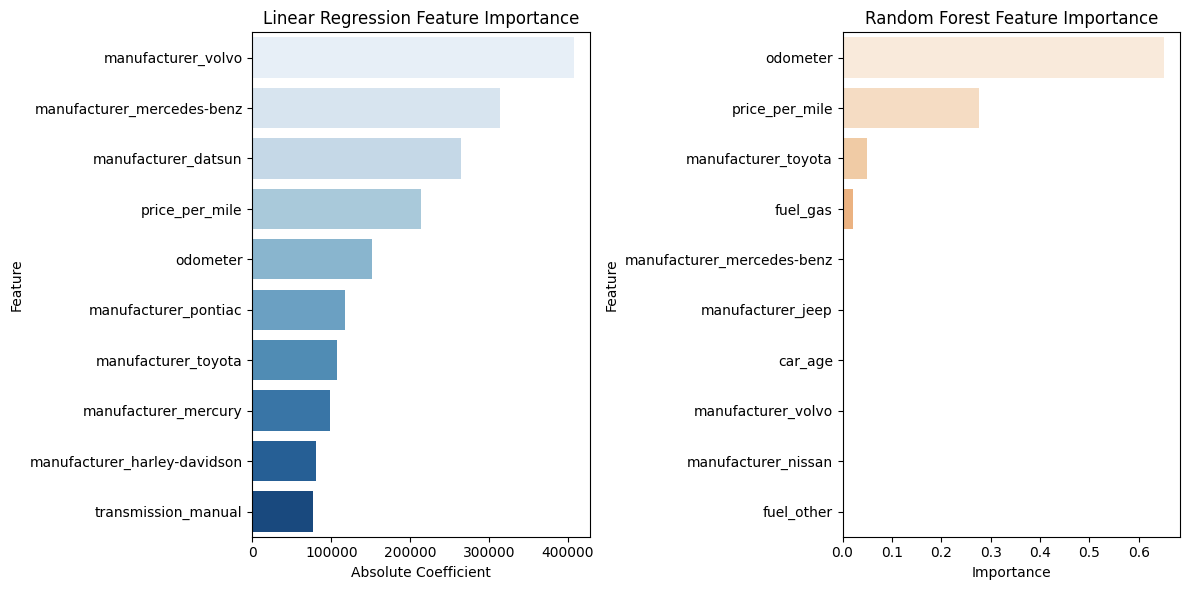

In [103]:
# Extract feature importance from Linear Regression
lr_coefficients = model_pipeline.named_steps['model'].coef_
lr_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coefficients,
    'Absolute_Coefficient': np.abs(lr_coefficients)
})

# Extract feature importance from Random Forest
rf_importance = rf_pipeline.named_steps['model'].feature_importances_
rf_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importance
})

# Sort both DataFrames by absolute importance/coefficients
lr_feature_importance = lr_feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)
rf_feature_importance = rf_feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance comparison
plt.figure(figsize=(12, 6))

# Linear Regression Feature Importance
plt.subplot(1, 2, 1)
sns.barplot(x=lr_feature_importance['Absolute_Coefficient'][:10], 
            y=lr_feature_importance['Feature'][:10], palette="Blues")
plt.title("Linear Regression Feature Importance")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")

# Random Forest Feature Importance
plt.subplot(1, 2, 2)
sns.barplot(x=rf_feature_importance['Importance'][:10], 
            y=rf_feature_importance['Feature'][:10], palette="Oranges")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.